### See if the necessary packages are installed and if not, install them. Then setup the rest of the notebook

Just a call in case the necessary packages to execute pystan (and pystan in a notebook)

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install -q pystan nest_asyncio pandas numpy seaborn

In [3]:
# nest_asyncio is needed for running pystan in a notebook
import nest_asyncio
nest_asyncio.apply()

In [4]:
import stan
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import time

In [5]:
# Constants
reference_data_path = "~/Downloads/train.csv"
random_seed = 42
date_start = datetime(2018, 12, 1)
date_end = datetime(2019, 5, 1)
avg_installs_per_day = 50 # use a small sample of the data, to make the time-series more noisy for the exercise
sample_size = (date_end - date_start).days * avg_installs_per_day

## Load the data from Kaggle 
- we are going to use just a small sample of the original data, restricting it both in span of days and in the number of users
- the reason to reduce the number of days is merely to decrease total computation time
- the reason to reduce the number of users is to make the average LTV per day more noisy, thus being more similar to the more challenging scenarios seen in the industry

In [6]:
# load data from https://www.kaggle.com/datasets/baetulo/lifetime-value?select=train.csv
data = pd.read_csv(reference_data_path)

In [7]:
# cast join_date to int (days since date_start) to pass it to stan
data['join_date'] = pd.to_datetime(data['join_date'])
data = data[(data['join_date'] >= date_start) & (data['join_date'] <= date_end)]
data['join_date'] = (data['join_date'] - date_start).dt.days.values
# get just a small subsample
sampled_data = data.sample(sample_size, random_state=random_seed)

In [8]:
# we say that the 'true value' (which we normally don't know), is defined by the average of all the users
true_value_data = data.groupby(['join_date'])['target'].mean().reset_index()

In [9]:
# group values per day, so that we have a time-series of the average LTV of this product
def summary(x):
    output = {}
    output['sampled_value'] = np.mean(x['target'])
    output['sampled_stddev'] = np.std(x['target']) / np.sqrt(len(x['target'])) # stddev of the average, assuming normality
    output['samples'] = len(x['target'])
    return pd.Series(output)

time_series_data = sampled_data.groupby(['join_date']).apply(lambda x: summary(x)).reset_index()
time_series_data = pd.merge(time_series_data, true_value_data, on='join_date')
time_series_data.head(5)

,join_date,sampled_value,sampled_stddev,samples,target
0,0,8.445683,1.840426,61.0,7.002142
1,1,7.000267,1.844289,54.0,7.006056
2,2,5.106322,1.764365,49.0,6.586223
3,3,5.698645,1.569402,43.0,6.619023
4,4,4.280549,2.004523,57.0,6.766564


<AxesSubplot: xlabel='join_date', ylabel='sampled_value'>

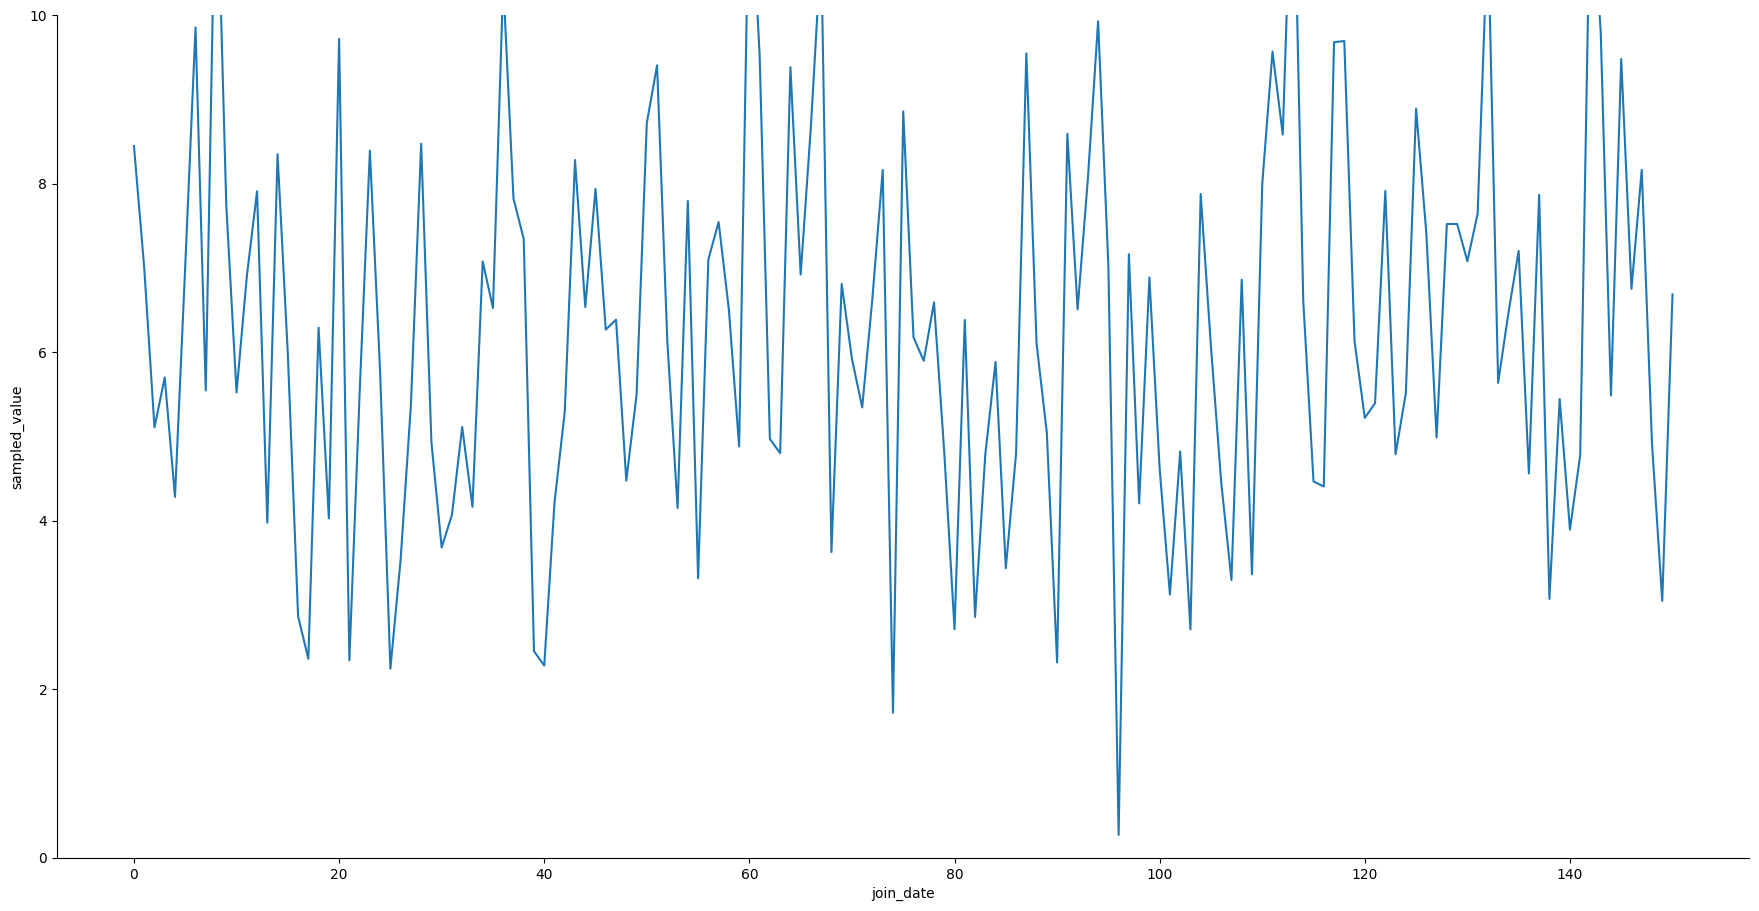

In [10]:
g = sns.relplot(time_series_data, x='join_date', y='sampled_value', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)
g.ax

## Model the time-series as a gaussian random walk
- define the stan model
- prepare the data for stan (it has to be passed as a dict)
- train the model (can take a long time, since it is basically estimate a distribution for each point)

In [17]:
time_series_model = """
data {
  int<lower=0> N;
  vector[N] sampled_value;
  vector[N] sampling_stddev;
}
parameters {
    vector[N] nu; //The random-walking signal
    real<lower=0> random_walk_stddev; // Standard deviation of random walk
}

model {
    random_walk_stddev ~ cauchy(0, 2); // Define the prior for the random walk stddev
    nu[1] ~ normal(6, 3); // initalize at a point with a fairly weak prior, but far from the truth, just to see convergence
    for (n in 2:N) {
        nu[n] ~ normal(nu[n-1], random_walk_stddev);
    }
    sampled_value ~ normal(nu, sampling_stddev);
}
"""

# get the data for STAN
stan_format_data = {}
stan_format_data['ts']= list(time_series_data.values)
stan_format_data['sampled_value']= list(time_series_data['sampled_value'].values)
stan_format_data['sampling_stddev']= list(time_series_data['sampled_stddev'].values)
stan_format_data['N']= time_series_data.shape[0]

In [18]:
# train the model
start_time = time.time()
# pass the model to STAN (doesn't 'train the model' per say)
posterior = stan.build(time_series_model, data=stan_format_data)
# sample (is the actually 'fit')
fit = posterior.sample(num_chains=2, num_samples=1000)
print(f"Training the modell took {time.time() - start_time} seconds")

Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 

Building: 29.7s
Building: 29.8s
Building: 30.0s
Building: 30.1s
Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.4s
Building: 31.6s
Building: 31.7s
Building: 31.8s
Building: 31.9s
Building: 32.0s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.5s
Building: 32.6s
Building: 32.7s
Building: 32.8s
Building: 33.0s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.5s
Building: 33.7s
Building: 33.8s
Building: 33.9s
Building: 34.0s
Building: 34.1s
Building: 34.2s
Building: 34.4s
Building: 34.5s
Building: 34.6s
Building: 34.7s
Building: 34.8s
Building: 34.9s
Building: 35.1s
Building: 35.2s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.8s
Building: 35.9s
Building: 36.0s
Building: 36.1s
Building: 36.2s
Building: 36.3s
Building: 36.4s
Building: 36.5s
Building: 36.7s
Building: 36.8s
Building

In file included from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/tamaki/.cache/httpstan/4.9.1/models/lmti5uto/model_lmti5uto.cpp:2:
/home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F

Building: 41.3s
Building: 41.4s
Building: 41.5s
Building: 41.6s
Building: 41.7s
Building: 41.9s
Building: 42.0s
Building: 42.1s
Building: 42.2s
Building: 42.3s
Building: 42.4s
Building: 42.5s
Building: 42.7s
Building: 42.8s
Building: 42.9s


/home/tamaki/.cache/httpstan/4.9.1/models/lmti5uto/model_lmti5uto.cpp: In instantiation of ‘void model_lmti5uto_namespace::model_lmti5uto::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/tamaki/.cache/httpstan/4.9.1/models/lmti5uto/model_lmti5uto.cpp:430:26:   required from here
/home/tamaki/.cache/httpstan/4.9.1/models/lmti5uto/model_lmti5uto.cpp:254:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  254 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 43.0s
Building: 43.1s
Building: 43.2s
Building: 43.3s


In file included from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/tamaki/.cache/httpstan/4.9.1/models/lmti5uto/model_lmti5uto.cpp:2:
/home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F

Building: 43.5s
Building: 43.6s
Building: 43.7s
Building: 43.8s


/home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/tamaki/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T

Building: 43.9s
Building: 44.0s
Building: 44.2s
Building: 44.3s
Building: 44.4s
Building: 44.5s
Building: 44.6s
Building: 44.7s
Building: 44.9s
Building: 45.0s
Building: 45.1s
Building: 45.2s
Building: 45.3s
Building: 45.4s
Building: 45.6s
Building: 45.7s
Building: 45.8s
Building: 45.9s
Building: 46.0s
Building: 46.1s
Building: 46.2s
Building: 46.3s
Building: 46.5s
Building: 46.6s
Building: 46.7s
Building: 46.8s
Building: 46.9s
Building: 47.0s
Building: 47.1s
Building: 47.3s
Building: 47.4s
Building: 47.5s
Building: 47.6s
Building: 47.7s
Building: 47.8s
Building: 48.0s
Building: 48.1s
Building: 48.2s
Building: 48.3s
Building: 48.4s
Building: 48.6s
Building: 48.7s
Building: 48.8s
Building: 48.9s
Building: 49.0s
Building: 49.1s
Building: 49.3s
Building: 49.4s
Building: 49.5s
Building: 49.6s
Building: 49.7s
Building: 49.8s
Building: 50.0s
Building: 50.1s
Building: 50.2s
Building: 50.3s
Building: 50.5s
Building: 50.6s
Building: 50.7s
Building: 50.8s
Building: 50.9s
Building: 51.1s
Building

Building: 73.2s
Building: 73.3s
Building: 73.4s
Building: 73.5s
Building: 73.7s
Building: 73.8s
Building: 73.9s
Building: 74.0s
Building: 74.1s
Building: 74.3s
Building: 74.4s
Building: 74.5s
Building: 74.6s
Building: 74.7s
Building: 74.8s
Building: 75.0s
Building: 75.1s
Building: 75.2s
Building: 75.3s
Building: 75.4s
Building: 75.6s
Building: 75.7s
Building: 75.8s
Building: 75.9s
Building: 76.0s
Building: 76.2s
Building: 76.3s
Building: 76.4s
Building: 76.5s
Building: 76.6s
Building: 76.7s
Building: 76.8s
Building: 77.0s
Building: 77.1s
Building: 77.2s
Building: 77.3s
Building: 77.4s
Building: 77.5s
Building: 77.6s
Building: 77.8s
Building: 77.9s
Building: 78.0s
Building: 78.1s
Building: 78.2s
Building: 78.3s
Building: 78.5s
Building: 78.6s
Building: 78.7s
Building: 78.8s
Building: 78.9s
Building: 79.0s
Building: 79.2s
Building: 79.3s
Building: 79.4s
Building: 79.5s
Building: 79.6s
Building: 79.7s
Building: 79.9s
Building: 80.0s
Building: 80.1s
Building: 80.2s
Building: 80.3s
Building

Building: 102.5s
Building: 102.6s
Building: 102.7s
Building: 102.8s
Building: 103.0s
Building: 103.1s
Building: 103.2s
Building: 103.3s
Building: 103.4s
Building: 103.5s
Building: 103.6s
Building: 103.8s
Building: 103.9s
Building: 104.0s
Building: 104.1s
Building: 104.2s
Building: 104.4s
Building: 104.5s
Building: 104.6s
Building: 104.7s
Building: 104.8s
Building: 105.0s
Building: 105.1s
Building: 105.2s
Building: 105.3s
Building: 105.4s
Building: 105.5s
Building: 105.7s
Building: 105.8s
Building: 105.9s
Building: 106.0s
Building: 106.1s
Building: 106.3s
Building: 106.4s


Building: 106.5s, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   2% (100/4000)
Sampling:   5% (200/4000)
Sampling:   8% (300/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1001/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (1200/4000)
Sampling:  32% (1300/4000)
Sampling:  35% (1400/4000)
Sampling:  38% (1500/4000)
Sampling:  40% (1600/4000)
Sampling:  42% (1700/4000)
Sampling:  45% (1800/4000)
Sampling:  48% (1900/4000)
Sampling:  50% (2000/4000)
Sampling:  50% (2001/4000)
Sampling:  52% (2100/4000)
Sampling:  55% (2200/4000)
Sampling:  58% (2300/4000)
Sampling:  60% (2400/4000)
Sampling:  62% (2500/4000)
Sampling:  65% (2600/4000)
Sampling:  68% (2700/4000)
Sampling:  70% (2800/4000)
Sampling:  72% (2900/4000)
Sampling:  75% (3001/4000)
Sampling:  78% (3100/4000)
Sampling:  80% (3200/4000)
Sampling:  82% (3300/4000)
Samplin

Training the modell took 161.9492700099945 seconds


In [19]:
model_data = fit.to_frame()  # get the samples from the estimated distribution of each parameter to a pandas DF

In [20]:
# Get the average and stddev of the estimates on each day
columns_ = model_data.reset_index().columns
columns_ = [x for x in columns_ if 'nu' in x]
simp_model_data = model_data[columns_]
avgs = np.mean(simp_model_data, axis=0).values
stddevs = np.std(simp_model_data, axis=0).values
simp_model_data = pd.DataFrame(
    {
        'join_date': time_series_data['join_date'],
        'estimated_value': avgs,
        'stddev': stddevs
    },
    columns=['join_date', 'estimated_value', 'stddev']
)

In [21]:
# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(time_series_data, simp_model_data, on='join_date')
plot_data = plot_data[['join_date', 'estimated_value', 'sampled_value', 'target']]
plot_data = pd.melt(plot_data, id_vars='join_date', value_vars=['estimated_value', 'sampled_value', 'target'])

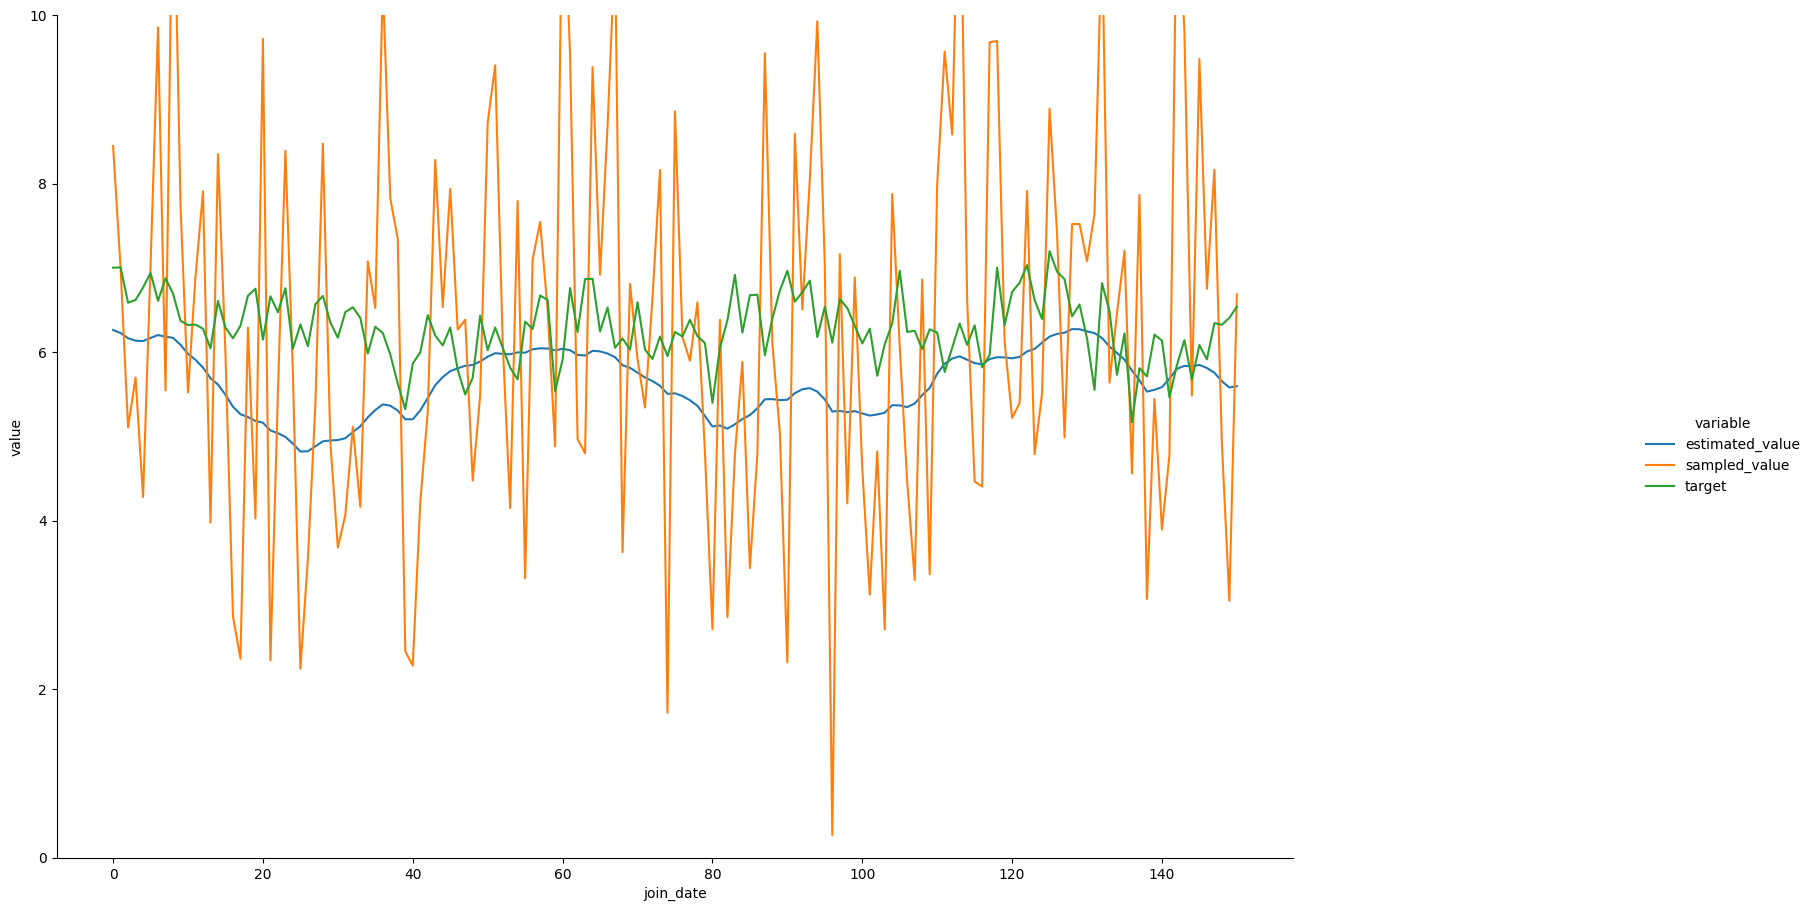

In [22]:
g = sns.relplot(plot_data, x='join_date', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)